In [1]:
%matplotlib inline

import numpy as np
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import gridded
#import gridded.pyugrid as pyugrid

print('gridded version: {}'.format(gridded.__version__))

gridded version: 0.1.0


c:\python35\lib\site-packages\matplotlib\ticker.py:1856: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


In [2]:
url = ('http://comt.sura.org/thredds/dodsC/data/comt_1_archive/'
       'inundation_tropical/VIMS_SELFE/Hurricane_Ike_3D_final_run_with_waves')
ds = gridded.Dataset(url)

In [3]:
# now we retrieve four different info from the read nc-file
# - type of grid
# - number of nodes
# - number of faces
# - vertices per face
print(ds.grid.info)

UGrid object:
Number of nodes: 592761
Number of faces: 1166747 with 3 vertices per face


In [4]:
# next, lets check the variables within the dataset"
print("variables available and their standard names:\n")
for name, var in ds.variables.items():
    try:
        print(name, ":", var.attributes['standard_name'])
    except KeyError:
        pass

variables available and their standard names:

wwm_9 : sea_surface_wave_period_at_variance_spectral_density_maximum
wwm_3 : sea_surface_wave_period_at_variance_spectral_density_mean
depth : depth_below_geoid
wwm_1 : sea_surface_wave_significant_height
u : eastward_sea_water_velocity
v : northward_sea_water_velocity
elev : sea_surface_height_above_geoid
wwm_15 : sea_surface_wave_from_direction_at_variance_spectral_density_maximum


In [5]:
# we are interested in the sea surface height:
variable = 'sea_surface_wave_significant_height'
ssh = ds.variables['wwm_1']

In [6]:
ssh.attributes

{'coordinates': 'time y x',
 'location': 'node',
 'long_name': 'significant_wave_height',
 'mesh': 'selfe_mesh',
 'missing_value': -999.0,
 'standard_name': 'sea_surface_wave_significant_height',
 'units': 'm'}

In [7]:
def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60

# the first and last step of this variable are at?
start_time = ssh.time.min_time
end_time = ssh.time.max_time
print("minimum time:", start_time)
print("manimum time:", end_time)
time_arr = ssh.time.get_time_array()
print("timestep (day, hours, minutes):", days_hours_minutes(time_arr[1] - time_arr[0]))

minimum time: 2008-09-10 00:10:00
manimum time: 2008-09-18 00:00:00
timestep (day, hours, minutes): (0, 0, 10)


The dataset has nodes (or vertexes) representing a point in a 2D space, the faces (or polygons) correspond to a plane enclosed by a set of edges. Note that the dataset does might not contain the edges! If that is the case ee need to compute those:

In [8]:
try:
    _ = ssh.grid.edges.shape
    print('edges exist')
    print(_)
except AttributeError:
    print('edges not exist, set first')
    ssh.grid.build_edges()

edges not exist, set first


Let's take a quick look at the mesh.

In [28]:
# note that we are working with just the variable object now...
lon = ssh.grid.node_lon
lat = ssh.grid.node_lat
faces = ssh.grid.faces
edges = ssh.grid.edges

triang = tri.Triangulation(lon, lat, triangles=faces[0:3])

ValueError: triangles max element is out of bounds

In [34]:
faces[0:3].max()

124008

In [60]:
lon = np.random.randint(0,1000, size=[1,125000])
lat = np.random.randint(0,1000, size=[1,125000])

In [64]:
lon

array([[353, 325, 582, ..., 317, 107, 233]])

In [63]:
faces[0:3]
triang = tri.Triangulation(lon, lat, triangles=faces[0:3])

ValueError: x and y must be equal-length 1-D arrays

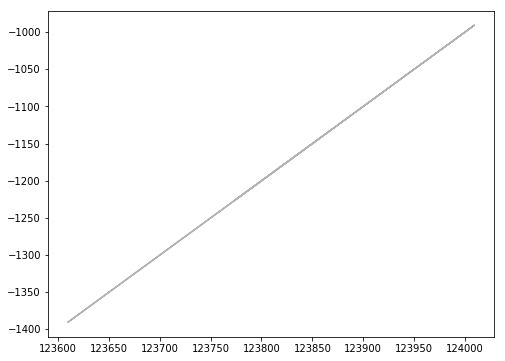

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.triplot(triang, '-k',alpha=0.3)

In [ ]:
# extract the data at the time we want:
# in this case, at the native nodes
data = ssh.at(ssh.grid.nodes, start_time)

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw=dict(projection=projection))
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [ ]:
bbox = [-84, -78, 25, 32]
contour_levels = np.arange(-0.5, 0.5, 0.2)  # Set the contour levels.
fig, ax = make_map()
ax.set_extent(bbox)
#Data grid lines
ax.triplot(triang, '-k',alpha=0.3)

#Contours
ax.tricontour(triang, data, colors='k', levels=contour_levels)
cs = ax.tricontourf(triang, data, levels=contour_levels)

cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)

time_string = start_time.isoformat()
title = ax.set_title('{}\n{}\n{}'.format(variable,
                                         time_string,
                                         ssh.attributes['standard_name']))